# Exploring our PDF File and what we can extract from it

In [1]:
from IPython.display import JSON
import json
from PIL import Image
from unstructured.partition.pdf import partition_pdf

In [2]:
# Returns a List[Element] present in the pages of the parsed pdf document
pdf_path = "data/losteria_ernaehrungsfibel_032022_interim_AT_website.pdf"
pdf_elements = partition_pdf(pdf_path, strategy="fast")

In [3]:
pdf_element_dict = [el.to_dict() for el in pdf_elements]


In [4]:
print(len(pdf_element_dict))


34


In [5]:
eti = pdf_element_dict[6] # element_to_inspect 
print(eti["text"])

PASTA Spaghetti Pomodoro e Basilico Spaghetti Rucola Pomodorini Risotto Funghi


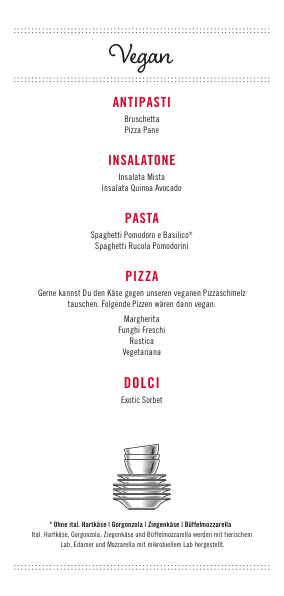

<class 'pymupdf.Pixmap'>


In [6]:
page_number = eti['metadata']['page_number']

import fitz  # PyMuPDF

def pdf_to_image(pdf_path, page_number):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number)
    pix = page.get_pixmap()
    # Assuming `image_bytes` contains the bytes of your image
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Display the image
    display(image)

    print(type(pix))
    pdf_document.close()

# Example usage
#pdf_path = "example.pdf"  # Replace with your PDF file path
#image_path = "output_image"  # Replace with the desired output image path (without extension)

pdf_to_image(pdf_path, page_number)

In [7]:
example_output = json.dumps(pdf_element_dict[11:15], indent=2)
JSON(example_output)

/Users/chbh01/opt/anaconda3/envs/llmexps2/lib/python3.8/site-packages/IPython/core/display.py:618: UserWarning: JSON expects JSONable dict or list, not JSON strings
  warnings.warn("JSON expects JSONable dict or list, not JSON strings")


<IPython.core.display.JSON object>

# Creating Vector Store for info in our PDF

In [8]:
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

from unstructured.chunking.title import chunk_by_title
from unstructured.chunking.base import ChunkingOptions

CHUNK_MAX_CHARS_DEFAULT = ChunkingOptions()._max_characters

import chromadb

In [9]:
chunks = chunk_by_title(pdf_elements)

for i in range(2):
    c = chunks[i]
    print("___________ Chunk : {c_num}, len: {curr_c_len} / {max_c_len}  ___________".format(c_num=i, curr_c_len=len(c.text), max_c_len=CHUNK_MAX_CHARS_DEFAULT ))
    #print("___________ Chunk " + str(i) + " len=" +str(len(c.text))+ " ___________" )
    print(c.text)
    print("___________ Chunk " + str(i) + " ___________" )

___________ Chunk : 0, len: 385 / 500  ___________
E R N Ä H R UNGSFIBEL

UNSERE EMPFEHLUNGEN

Mit dieser kleinen Fibel möchten wir Dir einen schnellen Überblick zu bestimmten Ernährungsgewohnheiten und Lebensmittelunverträglichkeiten geben.

Vegetarisch

ANTIPASTI Bruschetta Pizza Pane Crema di Pomodoro

INSALATONE Insalata Mista Insalata Quinoa Avocado

PASTA Spaghetti Pomodoro e Basilico Spaghetti Rucola Pomodorini Risotto Funghi
___________ Chunk 0 ___________
___________ Chunk : 1, len: 455 / 500  ___________
PIZZA Margherita Funghi Freschi Braccio di Ferro Rustica Parmigiana* Caprese Vegetariana Rucola*

DOLCI Spaghetti Eis Soufflé al Cioccolato Tiramisù Tartufo Crema di Fragola al Mascarpone

Vegan

ANTIPASTI Bruschetta Pizza Pane

INSALATONE Insalata Mista Insalata Quinoa Avocado

PASTA Spaghetti Pomodoro e Basilico* Spaghetti Rucola Pomodorini

PIZZA Gerne kannst Du den Käse gegen unseren veganen Pizzaschmelz tauschen. Folgende Pizzen wären dann vegan:
___________ Chunk 1 ____

## Converting the chunks into Documents/ Embeddings that can be fed into the LLM

In [10]:
documents = []
for element in chunks:
    metadata = element.metadata.to_dict()
    del metadata["languages"]
    metadata["source"] = metadata["filename"]
    documents.append(Document(page_content=element.text, metadata=metadata))

documents[page_number]

Document(page_content='Margherita Funghi Freschi Rustica Vegetariana\n\nDOLCI Exotic Sorbet\n\nOhne ital. Hartkäse | Gorgonzola | Ziegenkäse | Büffelmozzarella Ital. Hartkäse, Gorgonzola, Ziegenkäse und Büffelmozzarella werden mit tierischem Lab, Edamer und Mozzarella mit mikrobiellem Lab hergestellt.\n\nGlutenfrei\n\nANTIPASTI Caprese Carpaccio Crema di Pomodoro\n\nINSALATONE Insalata Mista Insalata Quinoa Avocado Insalata Casa Insalata Manzo Insalata Pollo Insalata Tonno e Fagioli Insalata Gamberi e Ceci', metadata={'file_directory': 'data', 'filename': 'losteria_ernaehrungsfibel_032022_interim_AT_website.pdf', 'filetype': 'application/pdf', 'last_modified': '2024-05-08T22:40:43', 'page_number': 3, 'source': 'losteria_ernaehrungsfibel_032022_interim_AT_website.pdf'})

### Open Source Embeddings

BGE Embeddings Model: https://arxiv.org/abs/2309.07597

In [11]:
model_name = "BAAI/bge-small-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_bge_embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

/Users/chbh01/opt/anaconda3/envs/llmexps2/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
sentence_embedding = hf_bge_embedding_model.embed_query(chunks[page_number].text)
print("_______________________________________________")
print("Input text:")
print( chunks[page_number])
print("_______________________________________________")
print("Output Sentence Embedding (length= {length}):".format(length=len(sentence_embedding)))
print(sentence_embedding)

_______________________________________________
Input text:
Margherita Funghi Freschi Rustica Vegetariana

DOLCI Exotic Sorbet

Ohne ital. Hartkäse | Gorgonzola | Ziegenkäse | Büffelmozzarella Ital. Hartkäse, Gorgonzola, Ziegenkäse und Büffelmozzarella werden mit tierischem Lab, Edamer und Mozzarella mit mikrobiellem Lab hergestellt.

Glutenfrei

ANTIPASTI Caprese Carpaccio Crema di Pomodoro

INSALATONE Insalata Mista Insalata Quinoa Avocado Insalata Casa Insalata Manzo Insalata Pollo Insalata Tonno e Fagioli Insalata Gamberi e Ceci
_______________________________________________
Output Sentence Embedding (length= 384):
[-0.04365277662873268, 0.03781253844499588, 0.012235515750944614, 0.039242323487997055, -0.018312223255634308, -0.056915465742349625, 0.03408006206154823, 0.048765335232019424, -0.05787795037031174, -0.01744038425385952, 0.0227345023304224, -0.08314866572618484, -0.02558574266731739, -0.011564431712031364, 0.0484674796462059, -0.09416192770004272, 0.06257347762584686, 0

In [13]:
# embeddings = OpenAIEmbeddings()
embeddings = hf_bge_embedding_model 
vectorstore = Chroma.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 6}
)

In [14]:
retriever.invoke("Pizza")

[Document(page_content='PIZZA Derzeit können wir leider keine glutenfreie Pizza anbieten. Dies liegt zum einen an der Rezeptur, zum anderen am Prozess und der zu starken Kreuzkontamination mit Mehl sowie Gries im Bereich der Pizzastation.\n\nDOLCI Spaghetti Eis Panna Cotta Exotic Sorbet\n\nLaktosefrei\n\nANTIPASTI Bruschetta Carpaccio (ohne Parmesan) Pizza Pane\n\nINSALATONE Insalata Mista Insalata Quinoa Avocado Insalata Pollo Insalata Tonno e Fagioli Insalata Gamberi e Ceci', metadata={'file_directory': 'data', 'filename': 'losteria_ernaehrungsfibel_032022_interim_AT_website.pdf', 'filetype': 'application/pdf', 'last_modified': '2024-05-08T22:40:43', 'page_number': 4, 'source': 'losteria_ernaehrungsfibel_032022_interim_AT_website.pdf'}),
 Document(page_content='PIZZA Margherita Funghi Freschi Braccio di Ferro Rustica Parmigiana* Caprese Vegetariana Rucola*\n\nDOLCI Spaghetti Eis Soufflé al Cioccolato Tiramisù Tartufo Crema di Fragola al Mascarpone\n\nVegan\n\nANTIPASTI Bruschetta Piz

In [15]:
retriever.invoke("Funghi")

[Document(page_content='PASTA Spaghetti Pomodoro e Basilico Spaghetti Rucola Pomodorini Zoodles Gamberetti\n\nPIZZA Gerne kannst Du den Käse gegen unseren veganen Pizzaschmelz tauschen. Folgende Pizzen sind dann laktosefrei:\n\nBBQ Chicken Braccio di Ferro Canarino Capricciosa Cip & Ciop Funghi Freschi Gamberetti Hawaii Margherita Marinara Nduja Calabrese Prosciutto Prosciutto e Funghi Prosciutto Crudo Rustica Salami Salsiccia Piccante Tonno Vegetariana Degli Artisi', metadata={'file_directory': 'data', 'filename': 'losteria_ernaehrungsfibel_032022_interim_AT_website.pdf', 'filetype': 'application/pdf', 'last_modified': '2024-05-08T22:40:43', 'page_number': 5, 'source': 'losteria_ernaehrungsfibel_032022_interim_AT_website.pdf'}),
 Document(page_content='PASTA Zoodles Gamberetti Risotto Funghi\n\nDu kannst unsere hausgemachte Pasta durch glutenfreie Penne oder Zoodles ersetzen. Folgende Gerichte können wir Dir dann empfehlen:\n\nSpaghetti Pomodoro e Basilico Spaghetti Carbonara Rigatoni

In [16]:
import openai
from langchain_openai import ChatOpenAI

In [17]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

In [18]:
from langchain.chains.summarize import load_summarize_chain 

# Get our chain, we use shain_type map_reduce and we run in parallel our first docs 
chain = load_summarize_chain(llm=llm, chain_type='map_reduce', verbose=True)# verbose=True optional to see what is getting sent to the LLM

output = chain.run(documents)
print (output) 

/Users/chbh01/opt/anaconda3/envs/llmexps2/lib/python3.8/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)




> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"E R N Ä H R UNGSFIBEL

UNSERE EMPFEHLUNGEN

Mit dieser kleinen Fibel möchten wir Dir einen schnellen Überblick zu bestimmten Ernährungsgewohnheiten und Lebensmittelunverträglichkeiten geben.

Vegetarisch

ANTIPASTI Bruschetta Pizza Pane Crema di Pomodoro

INSALATONE Insalata Mista Insalata Quinoa Avocado

PASTA Spaghetti Pomodoro e Basilico Spaghetti Rucola Pomodorini Risotto Funghi"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of the following:


"PIZZA Margherita Funghi Freschi Braccio di Ferro Rustica Parmigiana* Caprese Vegetariana Rucola*

DOLCI Spaghetti Eis Soufflé al Cioccolato Tiramisù Tartufo Crema di Fragola al Mascarpone

Vegan

ANTIPASTI Bruschetta Pizza Pane

INSALATONE Insalata Mista Insalata Quinoa Avocado

PASTA Spaghetti Pomodoro e Basilico* Spaghetti Rucola Pomodorini

PIZZA Gerne kannst Du d

# Retrieval Augmented Generation

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain_core.prompts import ChatPromptTemplate

messages = [
    ("system", "You are an AI assistant for answering questions about the menu items of the Losteria restaurant. You are given the following extracted parts of a long document and a question. Provide a conversational answer. If you don't know the answer, just say <Hmm, I'm not sure.> Don't try to make up an answer. If the question is not about ordering food from Losteria, politely inform them that you are tuned to only answer questions about Losteria."),
    ("human", "{question}"),
    ("system", "These is the relevant information from the menu for the question: {context}"),
]

prompt = ChatPromptTemplate.from_messages(messages)


In [20]:
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

In [21]:
history = []

chain = (
    { "question": RunnablePassthrough()
    ,"context": retriever | format_docs}
    | prompt
    | llm
    | StrOutputParser()
)

In [22]:
completion = chain.invoke("Which are the Vegan Pastas?", config={'callbacks': [ConsoleCallbackHandler()]})


[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Which are the Vegan Pastas?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context>] Entering Chain run with input:
{
  "input": "Which are the Vegan Pastas?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Which are the Vegan Pastas?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Which are the Vegan Pastas?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Which are the Vegan Pastas?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,context> > chain:RunnableSequence > chain:format_docs] Entering Chain run with input:
[inputs]
[ch

[llm/end] [chain:RunnableSequence > llm:ChatOpenAI] [1.23s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "The vegan pasta options at Losteria are Spaghetti Pomodoro e Basilico, Spaghetti Rucola Pomodorini, and Zoodles Gamberetti. You can also replace the cheese with their vegan pizza melt to make certain pizzas vegan.",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "The vegan pasta options at Losteria are Spaghetti Pomodoro e Basilico, Spaghetti Rucola Pomodorini, and Zoodles Gamberetti. You can also replace the cheese with their vegan pizza melt to make certain pizzas vegan.",
            "response_metadata": {
           

In [23]:
completion

'The vegan pasta options at Losteria are Spaghetti Pomodoro e Basilico, Spaghetti Rucola Pomodorini, and Zoodles Gamberetti. You can also replace the cheese with their vegan pizza melt to make certain pizzas vegan.'